<a href="https://colab.research.google.com/github/AmyBeisel/DS-Unit-4-Sprint-2-Neural-Networks/blob/master/module4-Hyperparameter-Tuning/LS_DS_424_Hyperparameter_Tuning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: [Available Here](https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv)

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [3]:
##### Your Code Here #####
# Load the data
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn+(1).csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
%%capture
!pip install -U pandas-profiling
!pip install category_encoders

In [0]:
# Get Profiling Report for the dataset
import numpy as np
from pandas_profiling import ProfileReport

profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

DATA Cleaning

In [2]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [0]:
#drop customerID
df = df.drop(['customerID'], axis=1)

#convert no/yes to 0 and 1
columns = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity',  
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
           'StreamingMovies', 'PaperlessBilling', 'Churn']

for col in columns:
  df[col] = [1 if x =='Yes'
              else 0 for x in df[col]]



#make total charges to go to cent.
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0).astype(float)

In [8]:
print(df.shape)
df.head()

(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [9]:
# OneHotEncode categorical variables
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df)
df_encoded.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,gender_Female,gender_Male,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_No phone service,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,29.85,29.85,0
1,0,1,0,0,0,34,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,56.95,1889.50,0
2,0,1,0,0,0,2,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,53.85,108.15,1
3,0,1,0,0,0,45,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,42.30,1840.75,0
4,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,70.70,151.65,1


Create and fit a baseline Keras MLP model to the data

In [30]:
feats = list(df_encoded)[:-1]
print(feats)
X = df_encoded[feats].values
y = df_encoded['Churn']


X.shape, y.shape

['gender_Female', 'gender_Male', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines_No phone service', 'MultipleLines_No', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'MonthlyCharges', 'TotalCharges']


((7043, 29), (7043,))

In [42]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

X = scaler.fit_transform(X)
X.shape

(7043, 29)

In [43]:
type(X)

numpy.ndarray

In [44]:
y = df_encoded['Churn'].values
y.shape

(7043,)

In [45]:
type(y)

numpy.ndarray

In [0]:
!pip install wandb

In [0]:
wandb_project = "dspt4_assignment"

In [13]:
!wandb login 143673a9eeadf68b7cee9f3b5558e58dcbcf1955

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [0]:
#Create and fit a baseline Keras MLP model to the data

#create model
model = Sequential()
model.add(Dense(64, input_dim = 29, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



In [36]:
#fit the model
hist = model.fit(X,y, epochs = 20)

Epoch 1/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4674 - accuracy: 0.7711
Epoch 2/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8014
Epoch 3/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8028
Epoch 4/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4141 - accuracy: 0.8059
Epoch 5/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4128 - accuracy: 0.8035
Epoch 6/20
221/221 [==============================] - 1s 2ms/step - loss: 0.4120 - accuracy: 0.8082
Epoch 7/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.8075
Epoch 8/20
221/221 [==============================] - 1s 2ms/step - loss: 0.4087 - accuracy: 0.8082
Epoch 9/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4083 - accuracy: 0.8083
Epoch 10/20
221/221 [==============================] - 0s 2ms/step - loss: 0.4068 - accuracy: 0.8090

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                1920      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.history.history.keys()

dict_keys(['loss', 'accuracy'])

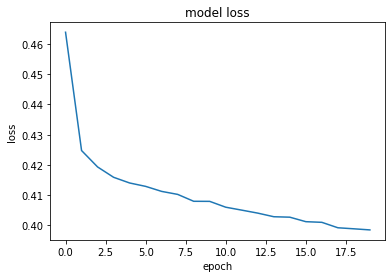

In [17]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [50]:
df_encoded['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

Hyperparameter tune (at least) the following parameters:
- batch_size
- training epochs
- optimizer
- learning rate (if applicable to optimizer)
- momentum (if applicable to optimizer)
- activation functions
- network weight initialization
- dropout regularization
- number of neurons in the hidden layer

You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters

In [0]:
#must do a train test split since this is a cross validation.  
#need a validation set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [0]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

seed = 42
np.random.seed(seed)

# Function to create model, required for KerasClassifier
def create_model():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation ='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = KerasClassifier(build_fn = create_model, verbose = 0)

# Define the grid search parameters
param_grid = {'epochs': [5, 10, 20, 50]}

# Create the GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

In [55]:
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Best: 0.8061315655708313 using {'epochs': 20}
Means: 0.7996932387351989, Stdev: 0.012058607171356728 with: {'epochs': 5}
Means: 0.7989365696907044, Stdev: 0.010235137330197059 with: {'epochs': 10}
Means: 0.8061315655708313, Stdev: 0.011005999485431999 with: {'epochs': 20}
Means: 0.798748779296875, Stdev: 0.008624943021203186 with: {'epochs': 50}


In [56]:
from tensorflow.keras.optimizers import SGD




# Function to create model, required for KerasClassifier
def create_model(learning_rate = 0.01, momentum = 0.0):
    sgd = SGD(learning_rate=learning_rate, momentum = momentum)
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation ='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Compile the model
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = KerasClassifier(build_fn = create_model, verbose = 0)

# Define the grid search parameters
param_grid = {'epochs': [50],
              'learning_rate': [0.001, 0.01, 0.1, 0.2],
              'momentum': [0, 0.5, 0.9, 0.99]}

# Create the GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.8019650697708129 using {'epochs': 50, 'learning_rate': 0.01, 'momentum': 0}
Means: 0.7834094882011413, Stdev: 0.01740783745076631 with: {'epochs': 50, 'learning_rate': 0.001, 'momentum': 0}
Means: 0.7983662366867066, Stdev: 0.014884521946921412 with: {'epochs': 50, 'learning_rate': 0.001, 'momentum': 0.5}
Means: 0.8004488587379456, Stdev: 0.016345364908540376 with: {'epochs': 50, 'learning_rate': 0.001, 'momentum': 0.9}
Means: 0.7989338755607605, Stdev: 0.014027705586449078 with: {'epochs': 50, 'learning_rate': 0.001, 'momentum': 0.99}
Means: 0.8019650697708129, Stdev: 0.01343673111796615 with: {'epochs': 50, 'learning_rate': 0.01, 'momentum': 0}
Means: 0.7985574126243591, Stdev: 0.011629203659229613 with: {'epochs': 50, 'learning_rate': 0.01, 'momentum': 0.5}
Means: 0.7949610829353333, Stdev: 0.008797384115278023 with: {'epochs': 50, 'learning_rate': 0.01, 'momentum': 0.9}
Means: 0.7862514734268189, Stdev: 0.014640618212242768 with: {'epochs': 50, 'learning_rate': 0.01, 'momen

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?